In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Predict Student Results/Code
!ls

/content/drive/MyDrive/Predict Student Results/Code
Clean_data.ipynb  data_cleaning.csv  Data.csv  EDA.ipynb  test.csv  train.csv


In [3]:
!pip install --quiet shap==0.39.0

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import shap

%matplotlib inline

sns.set_style('darkgrid')
pd. set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('data_cleaning.csv')

In [6]:
data

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,A06960,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.60,22.0,2.60,NaN,3.35,Tốt nghiệp Giỏi,4.0
1,A06961,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.50,19.0,2.50,NaN,2.55,Tốt nghiệp Khá,4.0
2,A06962,Kế toán doanh nghiệp,Nữ,0,3,A00,20.00,1,22,2.80,22.0,2.80,NaN,3.02,Tốt nghiệp Khá,4.0
3,A06963,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.25,19.0,2.25,NaN,2.52,Tốt nghiệp Khá,4.0
4,A06964,Kế toán doanh nghiệp,Nam,0,3,A00,20.00,1,22,2.20,22.0,2.20,NaN,2.09,Tốt nghiệp Trung bình,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175831,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,6,24,3.13,122.0,3.24,NaN,3.24,Tốt nghiệp Giỏi,4.0
175832,A27495,Ngôn ngữ Anh,Nữ,0,1,D01,25.00,7,3,2.33,131.0,3.18,NaN,3.24,Tốt nghiệp Giỏi,4.0
175833,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,5,18,3.33,87.0,2.96,NaN,3.21,Tốt nghiệp Giỏi,4.0
175834,A27497,Ngôn ngữ Anh,Nữ,0,1,D01,24.25,6,21,3.57,108.0,3.09,NaN,3.21,Tốt nghiệp Giỏi,4.0


## Goal

**Target feature**: *ket_qua_tn*

Các class phân bố không đều => Metric: **F1 score**, Precision, Recall

In [7]:
data.dtypes

id             object
nganh          object
gioi_tinh      object
doi_tuong       int64
khu_vuc        object
khoi_ts        object
diem_ts       float64
hoc_ky         object
dkhk            int64
tbhk          float64
tctl          float64
tbtl          float64
xlhv           object
diem_tn       float64
ket_qua_tn     object
nam_tn        float64
dtype: object

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175836 entries, 0 to 175835
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  int64  
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        3784 non-null    object 
 13  diem_tn     175836 non-null  float64
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(6), int64(2), object(8)
memory usage: 21.5+ MB


In [9]:
data['doi_tuong'] = data['doi_tuong'].astype(str)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175836 entries, 0 to 175835
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          175836 non-null  object 
 1   nganh       175836 non-null  object 
 2   gioi_tinh   175836 non-null  object 
 3   doi_tuong   175836 non-null  object 
 4   khu_vuc     175836 non-null  object 
 5   khoi_ts     175836 non-null  object 
 6   diem_ts     175357 non-null  float64
 7   hoc_ky      175836 non-null  object 
 8   dkhk        175836 non-null  int64  
 9   tbhk        175836 non-null  float64
 10  tctl        175802 non-null  float64
 11  tbtl        175836 non-null  float64
 12  xlhv        3784 non-null    object 
 13  diem_tn     175836 non-null  float64
 14  ket_qua_tn  175836 non-null  object 
 15  nam_tn      175836 non-null  float64
dtypes: float64(6), int64(1), object(9)
memory usage: 21.5+ MB


In [11]:
# print duplicates
print("Number of duplicates: ", data.duplicated().sum())
print("Unique values per column:")
data.nunique()

Number of duplicates:  483
Unique values per column:


id            24332
nganh            12
gioi_tinh         2
doi_tuong         7
khu_vuc           4
khoi_ts           6
diem_ts         271
hoc_ky           17
dkhk             56
tbhk            334
tctl            151
tbtl            261
xlhv              2
diem_tn         192
ket_qua_tn        4
nam_tn           13
dtype: int64

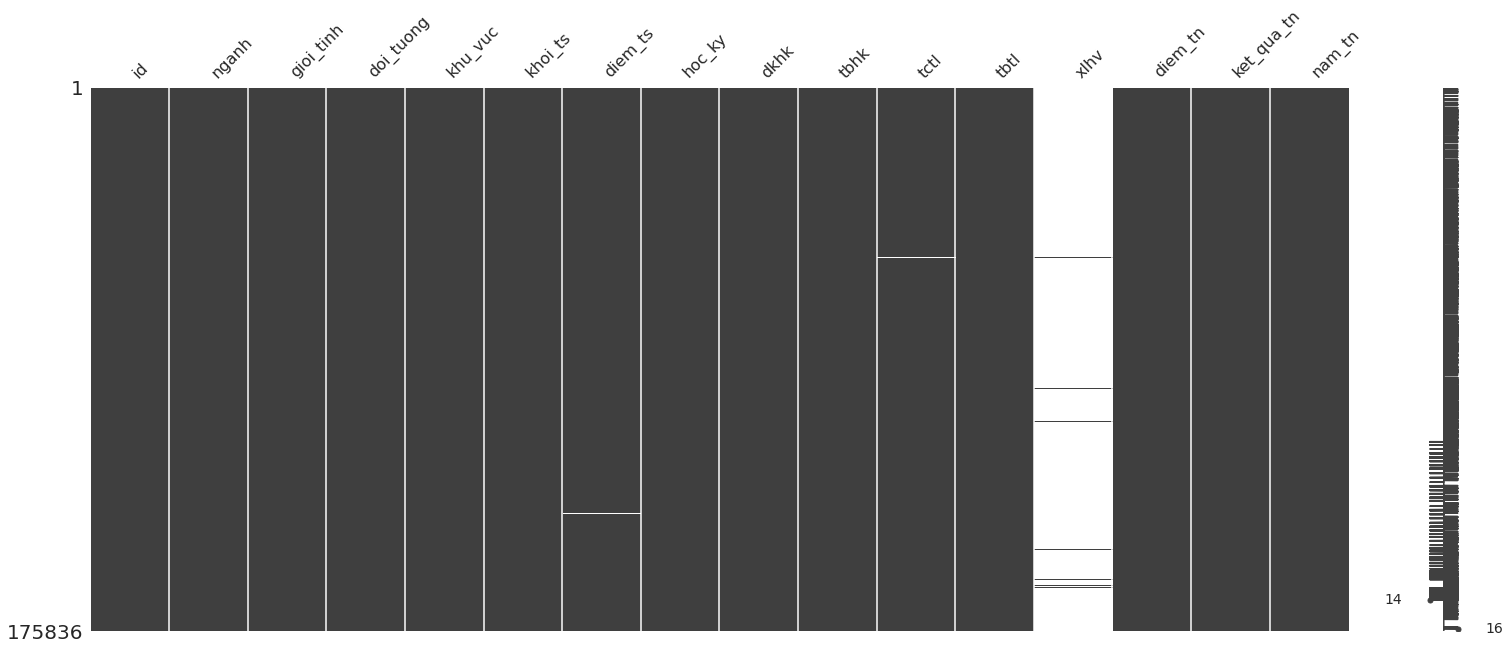

In [12]:
msno.matrix(data)

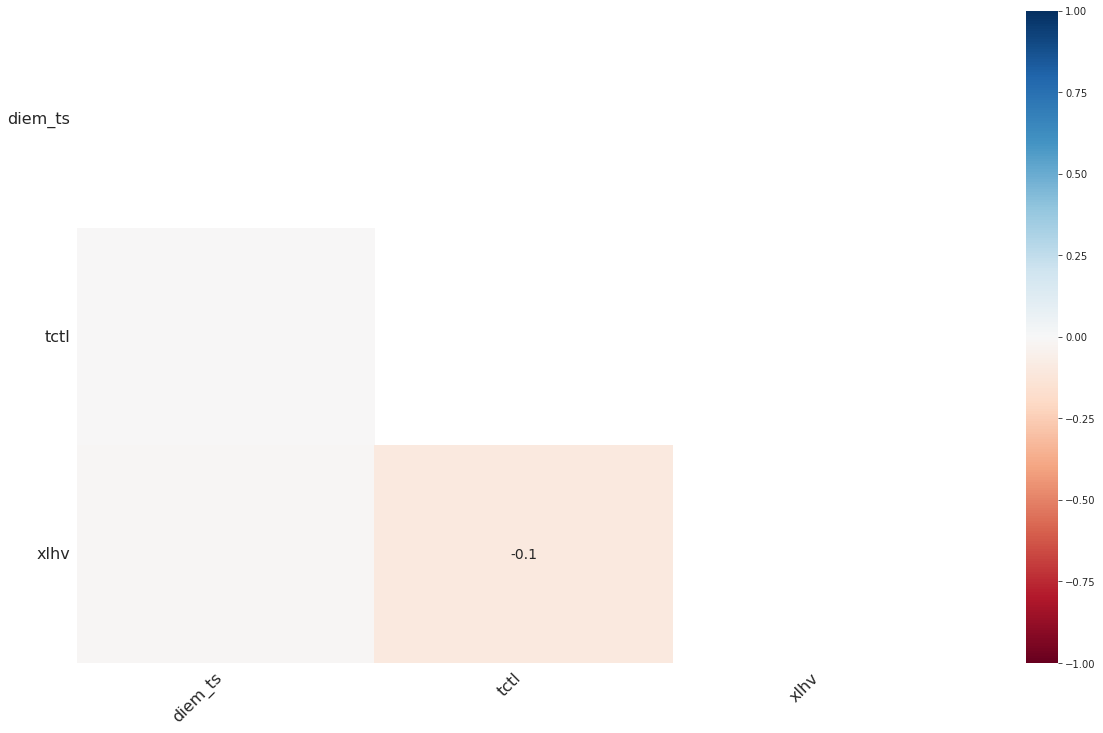

In [13]:
msno.heatmap(data)

Các feature chứa missing value không có tương quan với nhau

In [14]:
data['xlhv'].fillna('Binh thuong', inplace = True)

Các chỗ missing vale của *xlhv* có thể hiểu là không bị cảnh cáo học tập

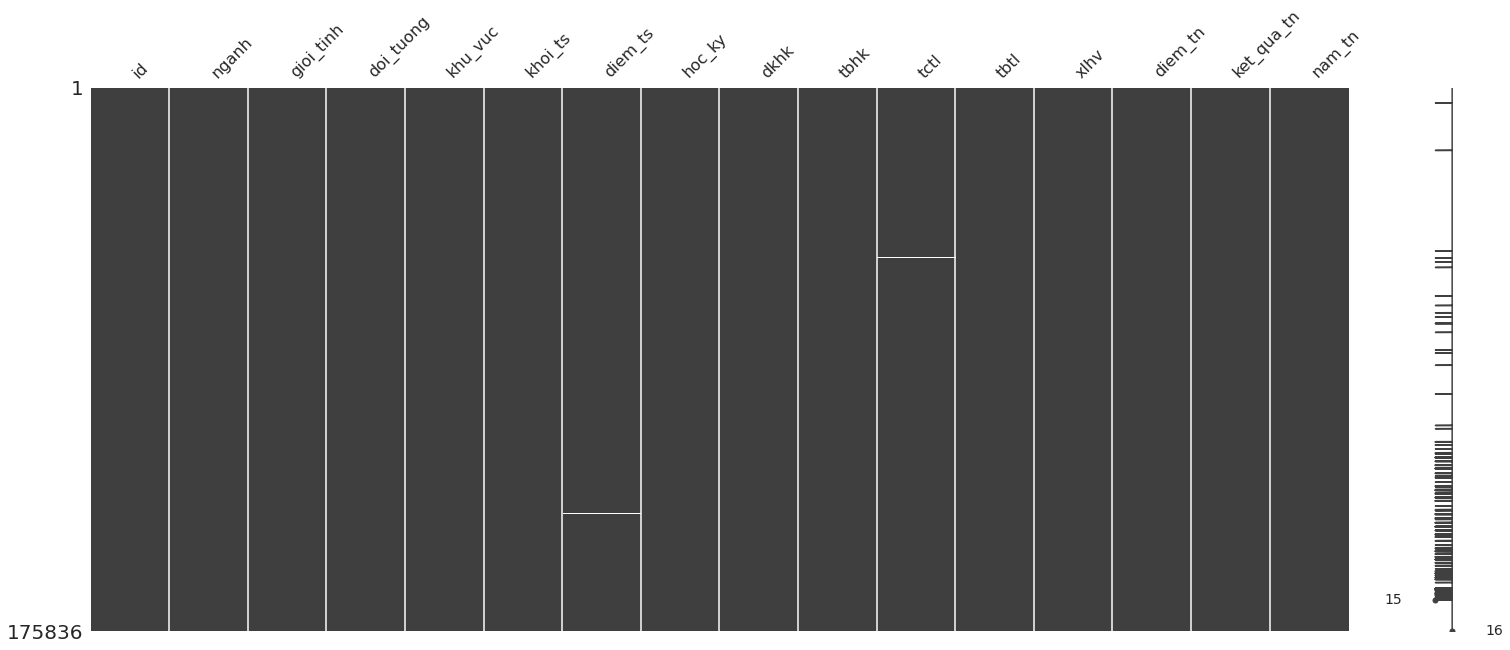

In [15]:
msno.matrix(data)

Điền các chỗ missing ằng các giá trị xuất hiện nhiều nhất

In [16]:
def mode_fill(data, column):
    col_mode = data[column].mode()[0]
    data[column].fillna(col_mode, inplace = True)

In [17]:
mode_fill(data, 'diem_ts')
mode_fill(data, 'tctl')

In [18]:
data.isna().sum()

id            0
nganh         0
gioi_tinh     0
doi_tuong     0
khu_vuc       0
khoi_ts       0
diem_ts       0
hoc_ky        0
dkhk          0
tbhk          0
tctl          0
tbtl          0
xlhv          0
diem_tn       0
ket_qua_tn    0
nam_tn        0
dtype: int64

# Univariate analysis

## Numerical

In [19]:
data.describe()

,diem_ts,dkhk,tbhk,tctl,tbtl,diem_tn,nam_tn
count,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000,175836.000000
mean,21.779045,18.064941,2.719822,81.259247,2.731157,2.837548,4.160272
std,2.151598,5.501685,0.736002,40.943768,0.438994,0.419790,0.467681
min,14.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.500000
25%,20.500000,16.000000,2.330000,48.000000,2.440000,2.560000,4.000000
50%,21.750000,18.000000,2.800000,84.000000,2.710000,2.800000,4.000000
75%,23.000000,22.000000,3.200000,116.000000,3.040000,3.160000,4.000000
max,30.000000,72.000000,4.000000,162.000000,4.000000,4.000000,8.500000


In [20]:
px.violin(
    data,
    x = 'diem_ts',
    box = True,
    points = 'all'
)

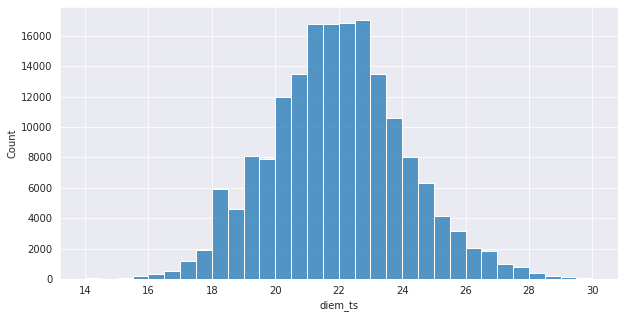

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(data['diem_ts'],bins = 32)
plt.show()

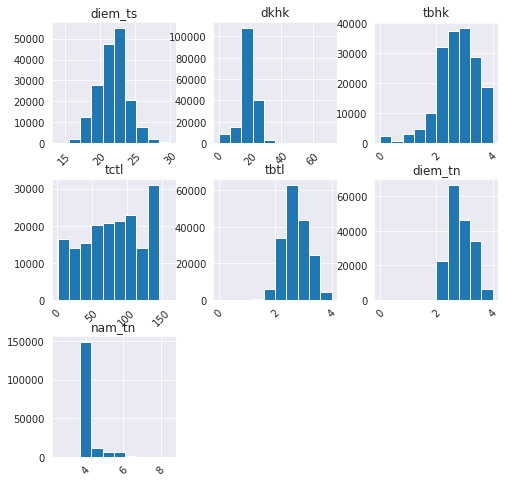

In [22]:
data.hist(figsize=(8,8), xrot=45)
plt.show()

## Categorical

In [23]:
data.describe(include='object')

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,hoc_ky,xlhv,ket_qua_tn
count,175836,175836,175836,175836,175836,175836,175836,175836,175836
unique,24332,12,2,7,4,6,17,3,4
top,A06994,Ngân hàng,Nữ,0,2NT,A00,7,Binh thuong,Tốt nghiệp Khá
freq,16,53078,128919,164226,63060,135078,21461,172052,108092


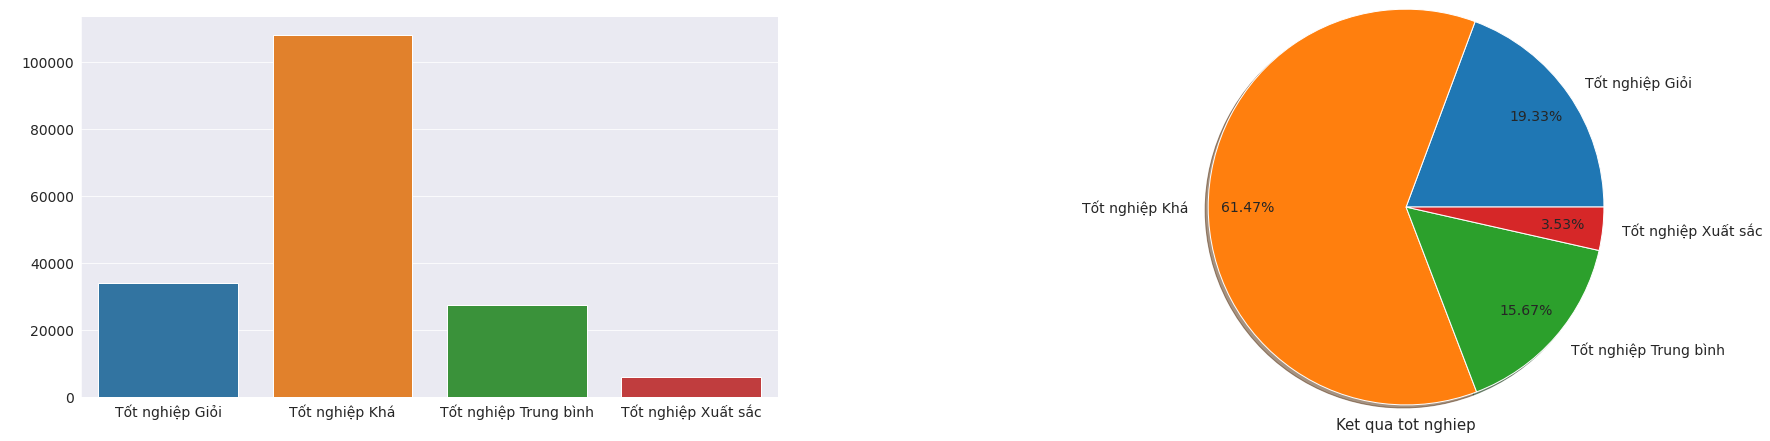

In [24]:
# checking the target
plt.figure(figsize=(30,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=data["ket_qua_tn"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(data["ket_qua_tn"].value_counts(sort = False),
        labels=list(data["ket_qua_tn"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Ket qua tot nghiep', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [25]:
data['hoc_ky'] = data['hoc_ky'].astype(str)

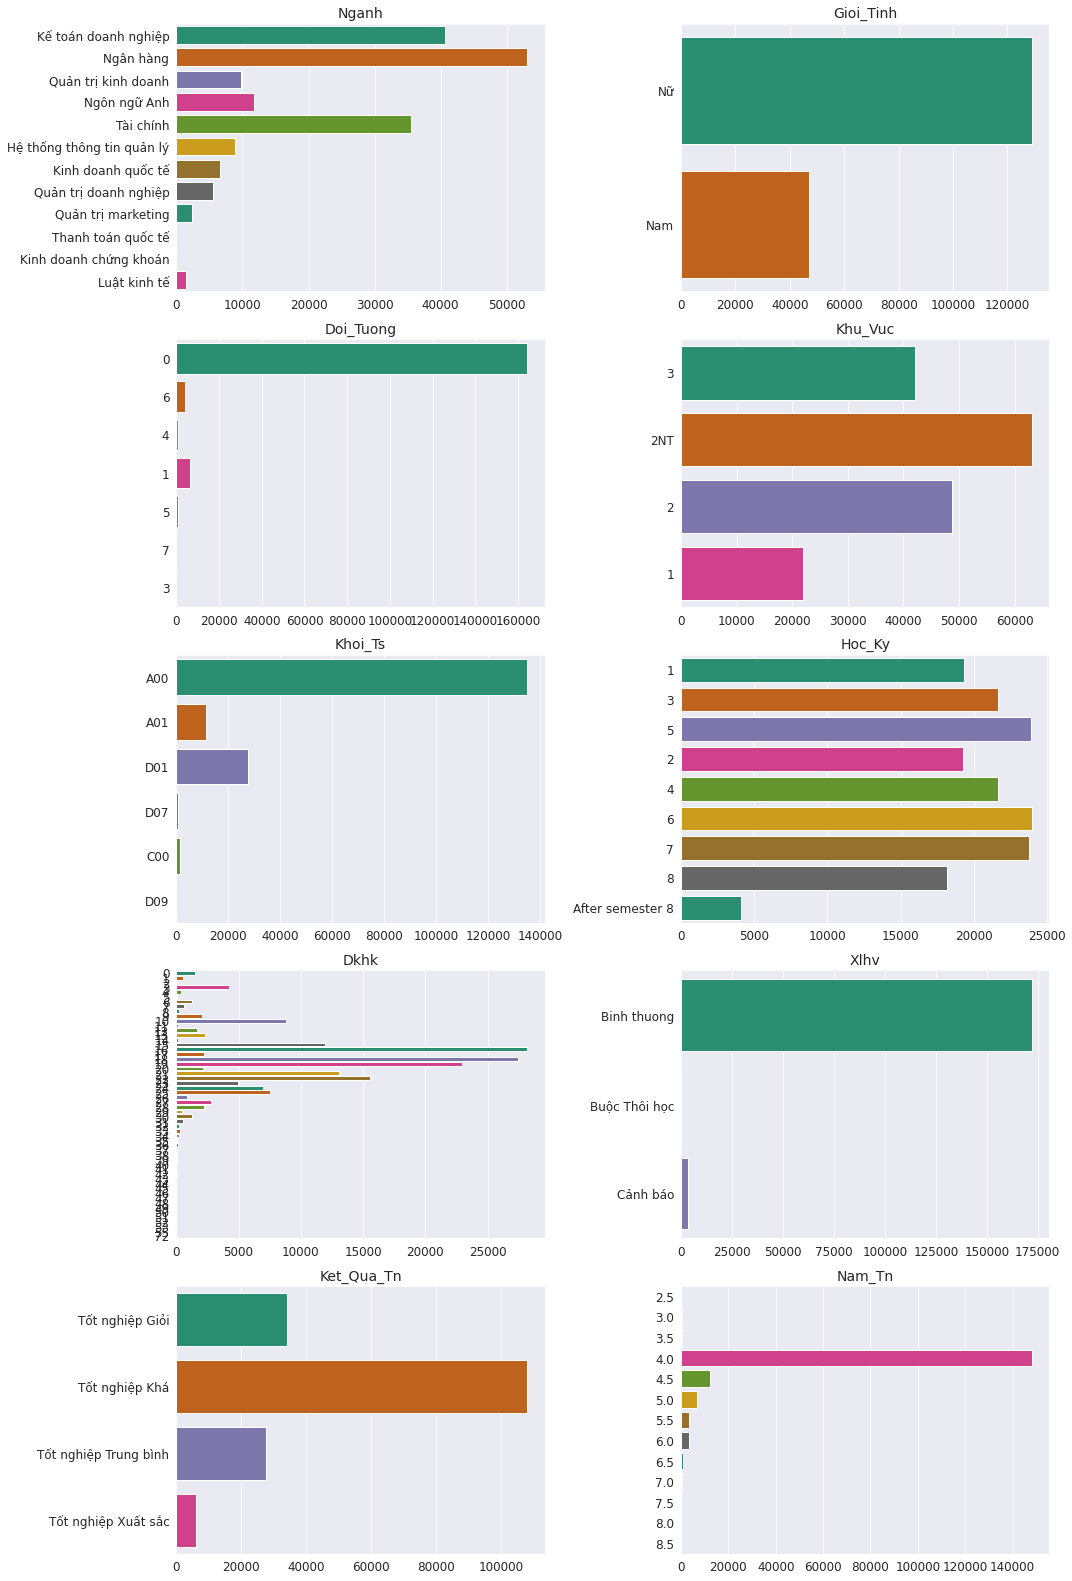

In [26]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in data.drop(['id', 'diem_tn', 'diem_ts', 'tbhk', 'tctl', 'tbtl'], axis=1):
    if plotnumber <= data.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=data, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

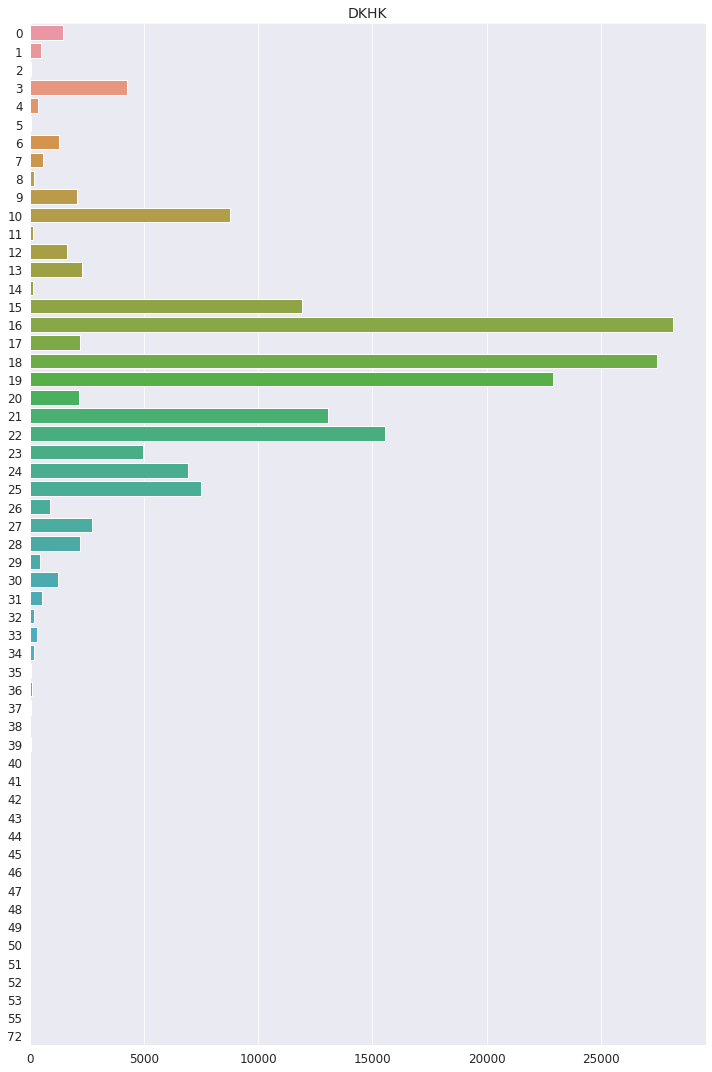

In [27]:
plt.figure(figsize=(10,15))
sns.countplot(data=data, y='dkhk')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('DKHK', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

**Sao lại đăng kì được 72 tín ????**

# Bivariate analysis

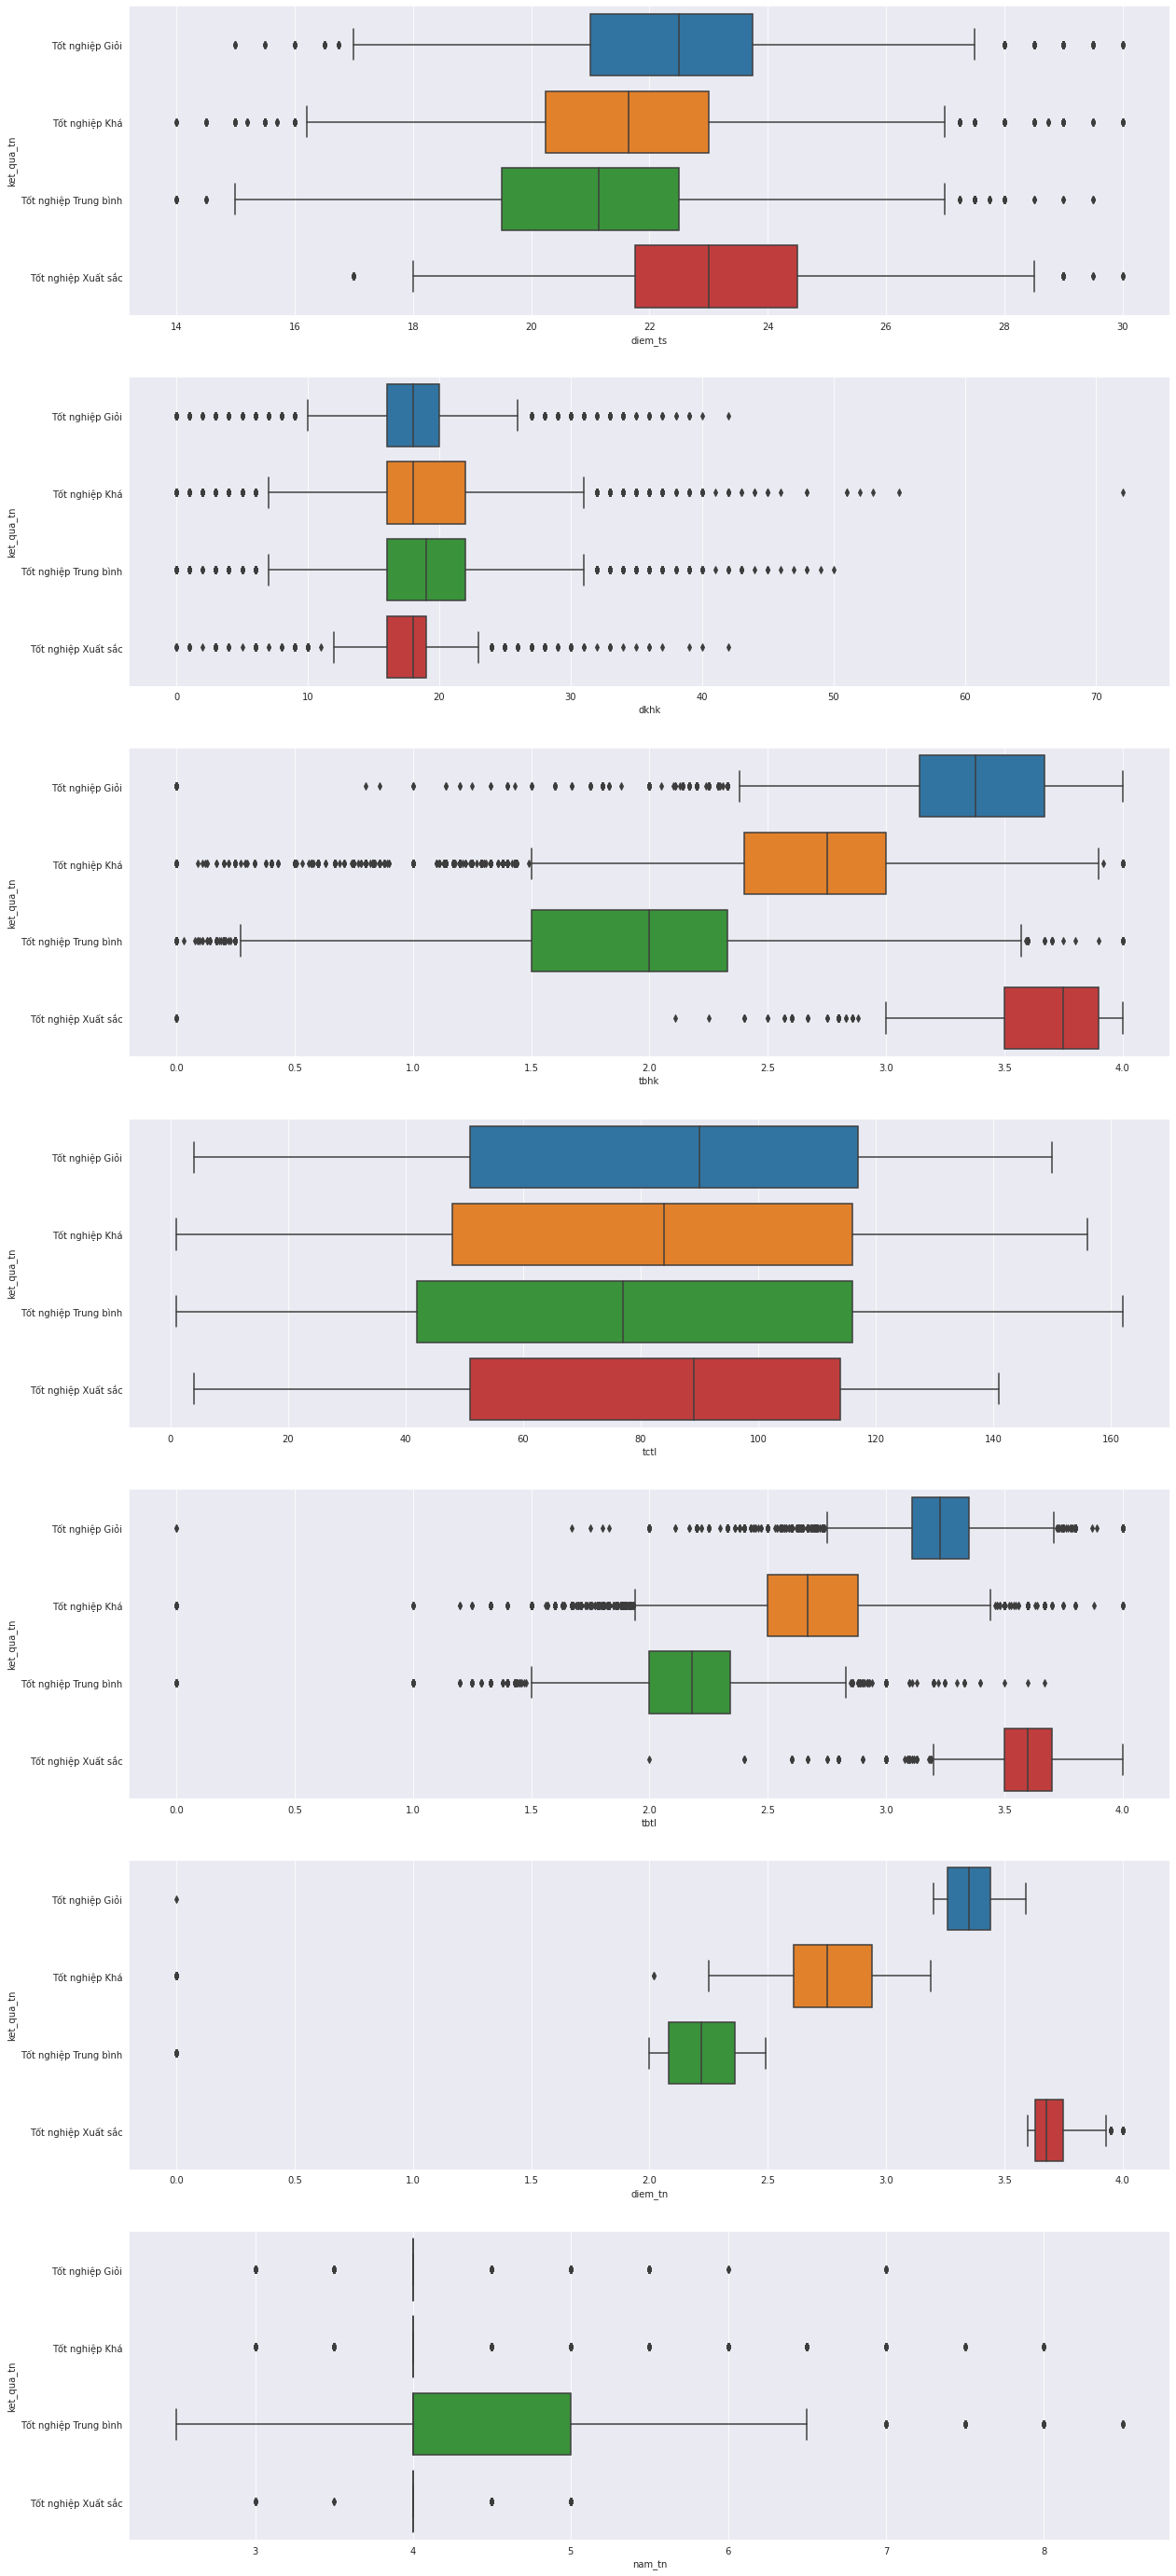

In [28]:
fig, axs = plt.subplots(7, 1, figsize = (20, 50))
num_cols = ['diem_ts', 'dkhk', 'tbhk', 'tctl', 'tbtl', 'diem_tn', 'nam_tn']
for idx, col in enumerate(num_cols):
    sns.boxplot(y = data['ket_qua_tn'], x = col, data=data, ax = axs[idx])
plt.show()

<Figure size 720x360 with 0 Axes>

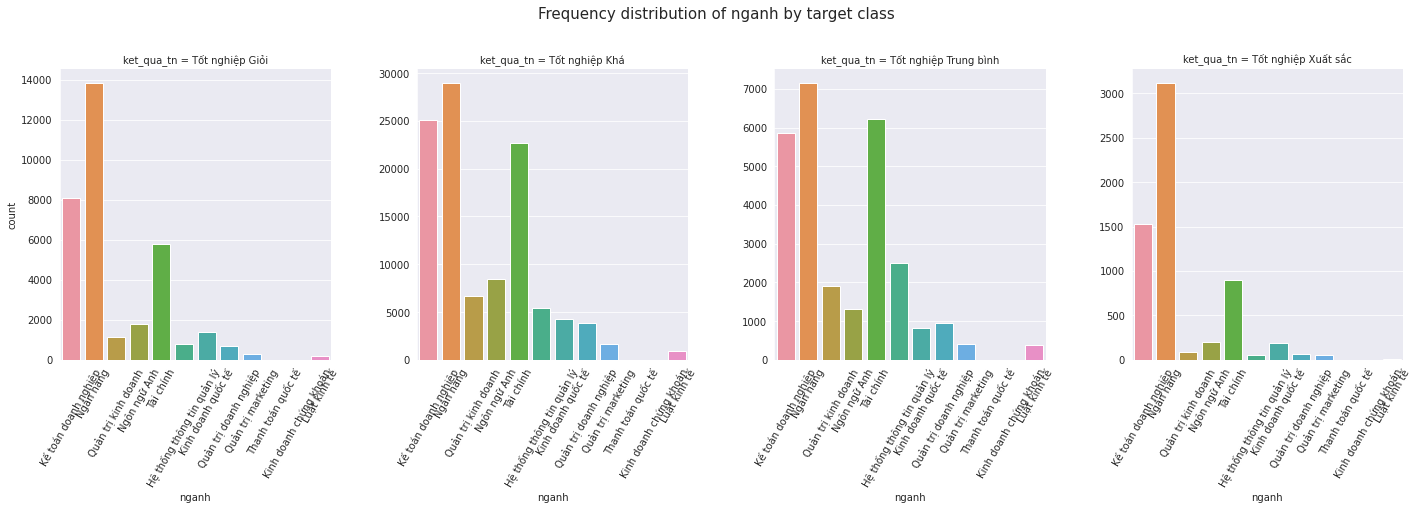

<Figure size 720x360 with 0 Axes>

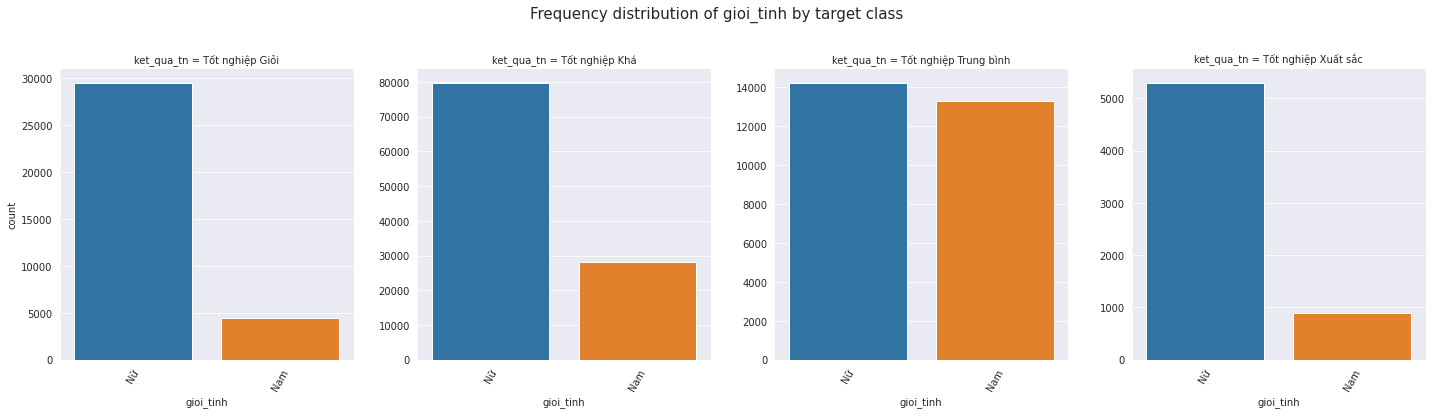

<Figure size 720x360 with 0 Axes>

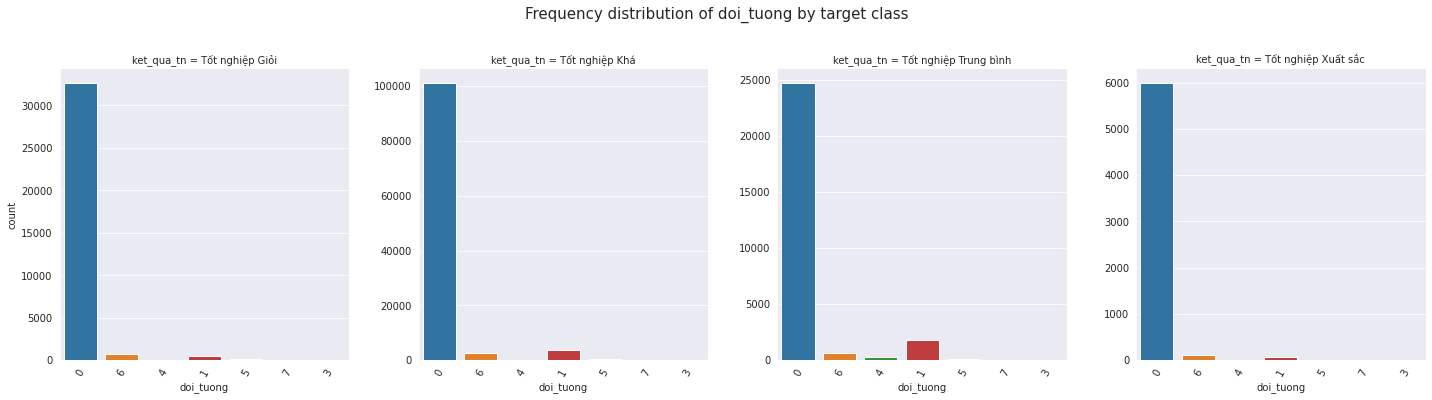

<Figure size 720x360 with 0 Axes>

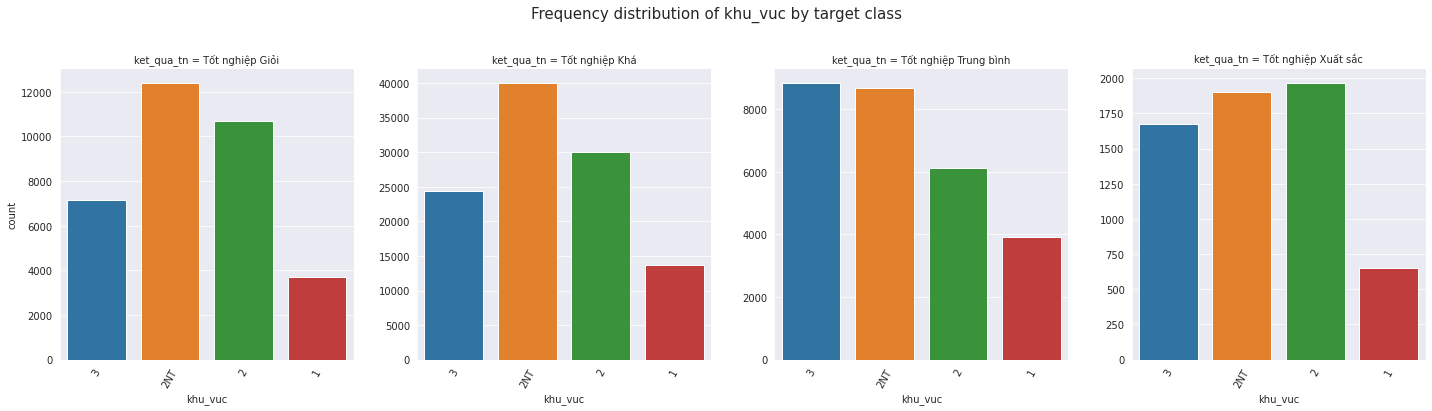

<Figure size 720x360 with 0 Axes>

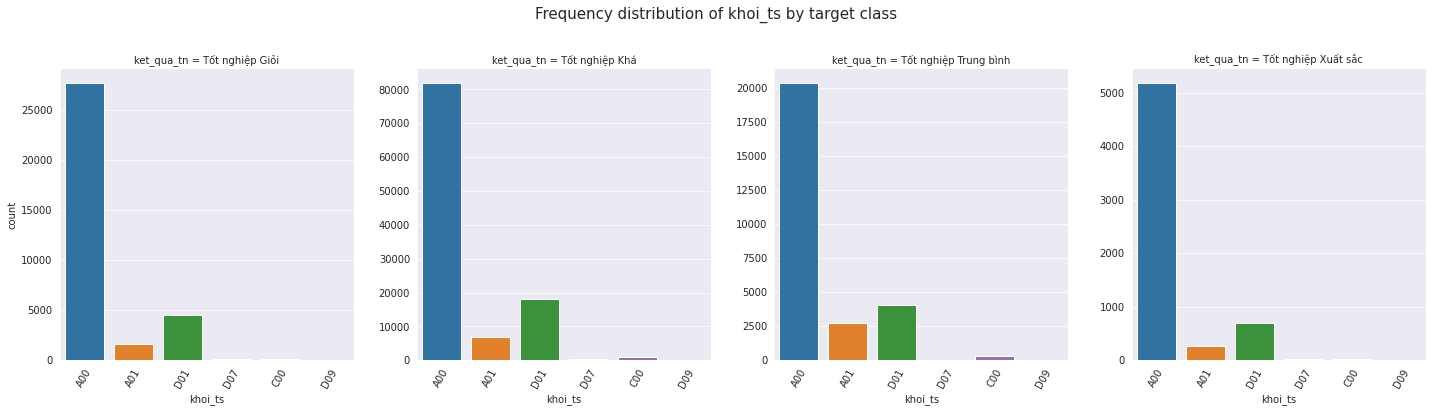

<Figure size 720x360 with 0 Axes>

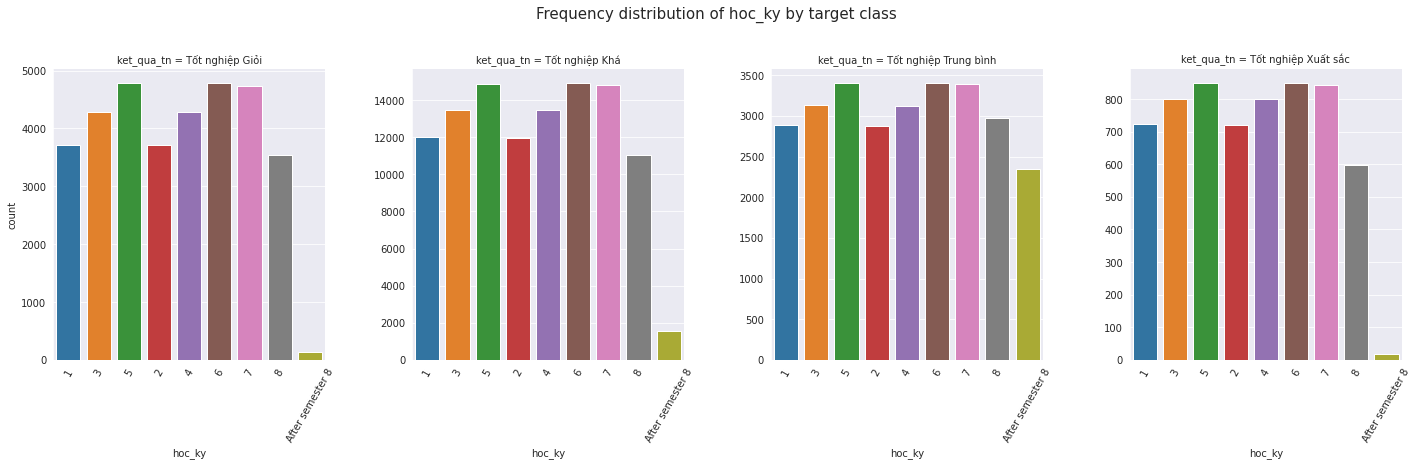

<Figure size 720x360 with 0 Axes>

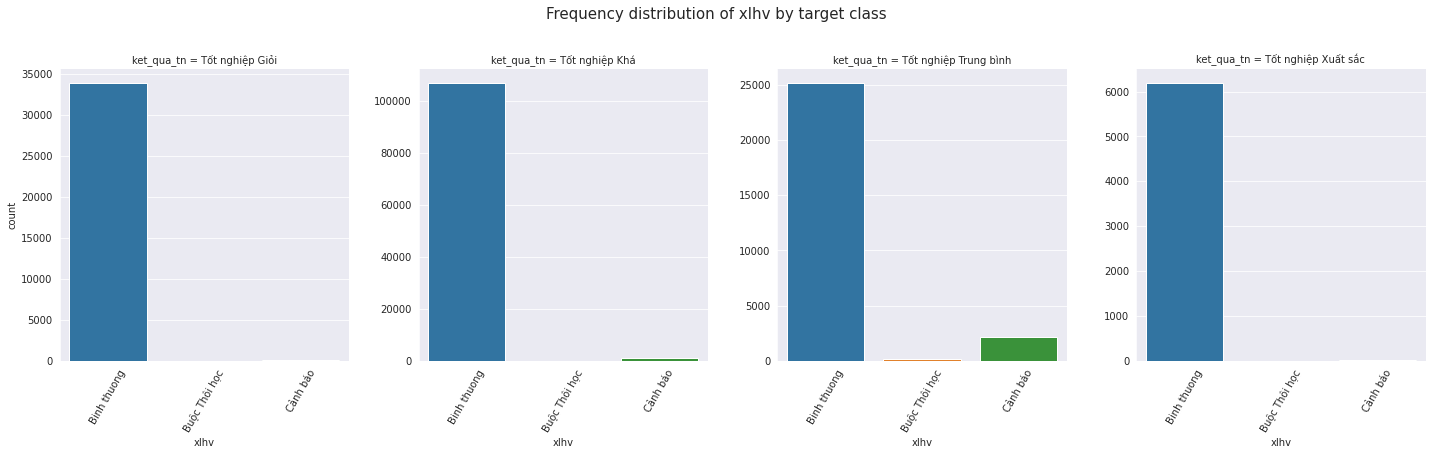

In [29]:
cat_features = ['nganh', 'gioi_tinh', 'doi_tuong',	'khu_vuc',	'khoi_ts',	'hoc_ky',	'xlhv']
for feature in cat_features:
    plt.figure(figsize = (10, 5))
    catplot = sns.catplot(data = data, x = feature, col = 'ket_qua_tn', kind = 'count', sharey = False)
    catplot.set_xticklabels(rotation = 60)
    plt.suptitle("Frequency distribution of {} by target class".format(feature), y = 1.1, fontsize = 15)
    plt.show()

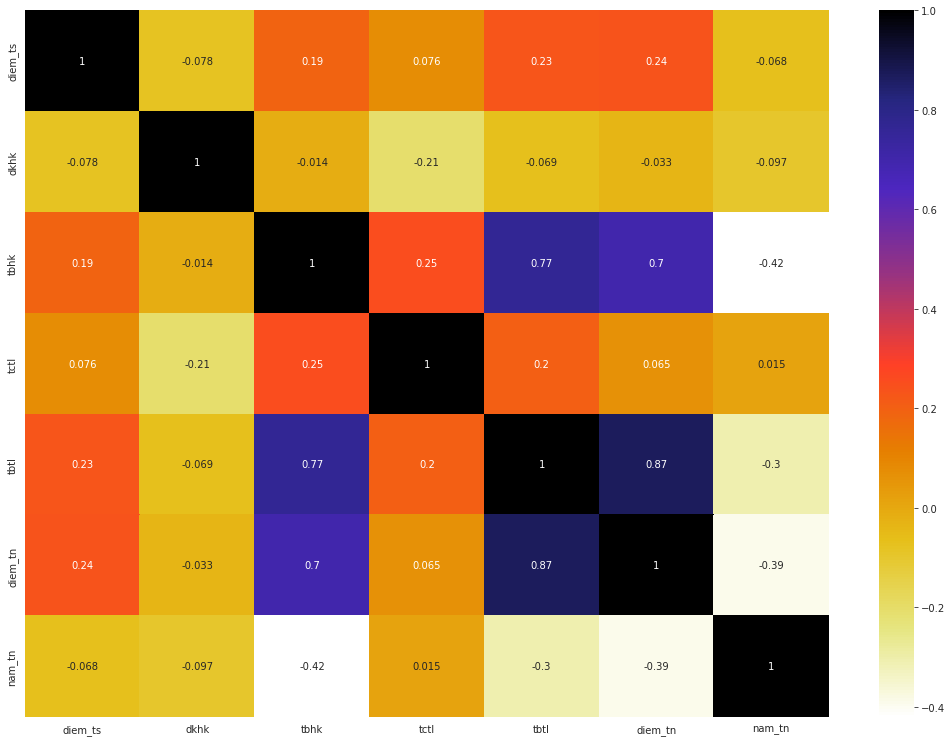

In [30]:
# Correlation structure of features
def heatmap(data):
    plt.figure(figsize = (18, 13))
    sns.heatmap(data.corr(), annot = True, cmap = plt.cm.CMRmap_r)

heatmap(data[num_cols])

Cột **tbtl, diem_tn, tbhk** có tương quan cao => Drop 2 trong 3 cột

# Data Processing

In [31]:
numerical_cols = ['diem_ts', 'dkhk', 'tbhk', 'tctl', 'tbtl', 'diem_tn', 'nam_tn']
ordinal_cols = ['hoc_ky', 'xlhv', 'ket_qua_tn']
nominal_cols = [x for x in data.columns if x not in numerical_cols + ordinal_cols]

In [32]:
def label_encoder(data, cols):
    data_le = data.copy(deep = True)
    le = LabelEncoder()
    for col in cols:    
        data_le[col] = le.fit_transform(data_le[col])
    return data_le

In [33]:
# Creating the mappings
hoc_ky_dict = {'1' : 1, '2' : 2, '3' : 3, '4' : 4, '5' : 5, '6' : 6, '7' : 7, '8' : 8, 'After semester 8' : 9}
xlhv_dict = {'Binh thuong' : 1, 'Cảnh báo' : 2, 'Buộc Thôi học' : 3}
ket_qua_tn_dict = {'Tốt nghiệp Xuất sắc': 1, 'Tốt nghiệp Giỏi': 2, 'Tốt nghiệp Khá': 3, 'Tốt nghiệp Trung bình': 4}

In [34]:
ordinal_encoder_dict = {'hoc_ky' : hoc_ky_dict,
                       'xlhv' : xlhv_dict,
                        'ket_qua_tn': ket_qua_tn_dict
                        }

In [35]:
def manual_encoder(data, ordinal_cols, ordinal_encoder_dict):
    data_me = data.copy(deep = True)
    for feature in data.columns:
        if feature in ordinal_cols:
            if feature != 'ket_qua_tn':
                data_me[feature] = data_me[feature].map(ordinal_encoder_dict[feature])
    return data_me

In [36]:
data = manual_encoder(data, ordinal_cols, ordinal_encoder_dict)
data = label_encoder(data, nominal_cols)
data.head()

,id,nganh,gioi_tinh,doi_tuong,khu_vuc,khoi_ts,diem_ts,hoc_ky,dkhk,tbhk,tctl,tbtl,xlhv,diem_tn,ket_qua_tn,nam_tn
0,6708,3,1,0,3,0,20.0,1,22,2.60,22.0,2.60,1,3.35,Tốt nghiệp Giỏi,4.0
1,6709,3,1,0,3,0,20.0,1,22,2.50,19.0,2.50,1,2.55,Tốt nghiệp Khá,4.0
2,6710,3,1,0,3,0,20.0,1,22,2.80,22.0,2.80,1,3.02,Tốt nghiệp Khá,4.0
3,6711,3,0,0,3,0,20.0,1,22,2.25,19.0,2.25,1,2.52,Tốt nghiệp Khá,4.0
4,6712,3,0,0,3,0,20.0,1,22,2.20,22.0,2.20,1,2.09,Tốt nghiệp Trung bình,4.0


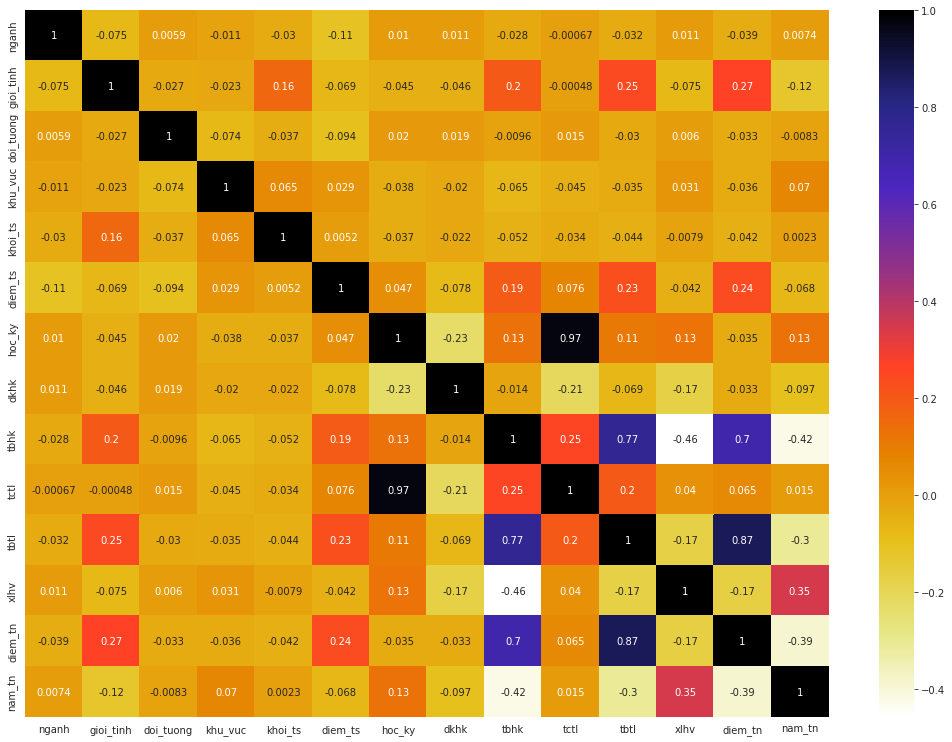

In [37]:
data_heat = data.drop(['id', 'ket_qua_tn'], axis = 1)
heatmap(data_heat)

- Cột **tbtl, diem_tn, tbhk** có tương quan cao
- Cột **tctl, hoc_ky** có tương quan cao

In [38]:
# Drop columns
drop_cols = ['tbhk', 'diem_tn', 'tctl', 'id']
data = data.drop(drop_cols, axis = 1)

In [39]:
def predictor_target_split(data, target):
    y = data[target] # target variable
    X = data.drop(target, axis = 1) 
    return X, y

X, y = predictor_target_split(data, 'ket_qua_tn')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [41]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(140668, 11) (35168, 11) (140668,) (35168,)


In [42]:
# SMOTE

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train.shape, y_train.shape)

Class= Tốt nghiệp Khá, n=86318 (61.36%)
Class= Tốt nghiệp Giỏi, n=27273 (19.39%)
Class= Tốt nghiệp Xuất sắc, n=4967 (3.53%)
Class= Tốt nghiệp Trung bình, n=22110 (15.72%)
Class= Tốt nghiệp Khá, n=86318 (25.00%)
Class= Tốt nghiệp Giỏi, n=86318 (25.00%)
Class= Tốt nghiệp Xuất sắc, n=86318 (25.00%)
Class= Tốt nghiệp Trung bình, n=86318 (25.00%)
Upsampled data shape:  (345272, 11) (345272,)


In [44]:
# Encoding the target variable
y_train = y_train.map(ordinal_encoder_dict['ket_qua_tn'])
y_test = y_test.map(ordinal_encoder_dict['ket_qua_tn'])

In [47]:
estimator = XGBClassifier(n_estimators = 113, learning_rate = 0.1, n_jobs = -1)
selector = RFE(estimator, n_features_to_select = 11, step = 1)
selector = selector.fit(X_train, y_train)

In [51]:
dict = {'Feature': X_train.columns, 'Ranking': selector.ranking_}
ranking_df = pd.DataFrame(dict)
ranking_df

,Feature,Ranking
0,nganh,1
1,gioi_tinh,1
2,doi_tuong,1
3,khu_vuc,1
4,khoi_ts,1
5,diem_ts,1
6,hoc_ky,1
7,dkhk,1
8,tbtl,1
9,xlhv,1


In [57]:
# Computation of confusion matrix
def conf_mat(y_pred, y_test):
    class_names = ['Tốt nghiệp Xuất sắc', 'Tốt nghiệp Giỏi', 'Tốt nghiệp Khá', 'Tốt nghiệp Trung bình']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    conf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_df = pd.DataFrame(conf_matrix, range(4), range(4))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'horizontal')
    plt.xticks(tick_marks_x, class_names, rotation = 'vertical')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [55]:
f1_dict = {}

Weighted F1-score on the test set: 0.8389970320110584


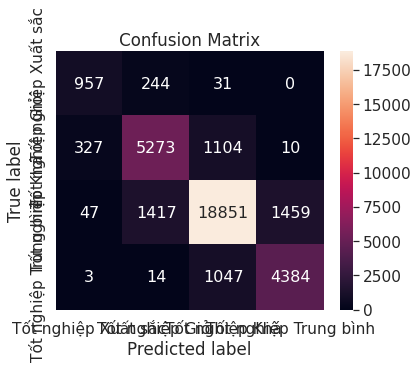

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best weighted F1-score: 0.9233899840663744
 
Weighted F1-score on the test set: 0.838620550965048


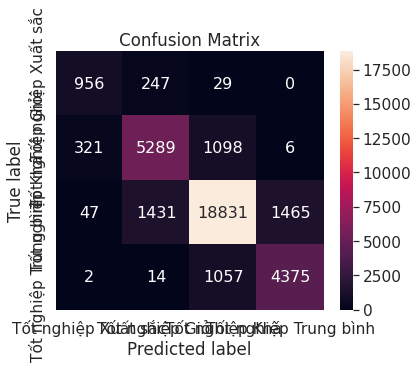

In [59]:
f1_dict_ht = {}

# Hyperparameter tuning for Random Forest
cv = KFold(n_splits = 5, shuffle = True, random_state = 20).split(X = X_train, y = y_train)
rf = RandomForestClassifier()
params_rf = {'n_estimators': [100, 200],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None],
          'max_features': ['auto', 'sqrt', 'log2'],
          'class_weight': ['balanced', None]
          }
gsearch_rf = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_rf_fit = gsearch_rf.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_rf.best_params_))
print("Best weighted F1-score: {}".format(gsearch_rf.best_score_))
print(" ")

# Random Forest model evaluation on the test set
rf_best = gsearch_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
score = f1_score(y_test, y_pred_rf, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['Random Forest'] = score
conf_mat(y_pred_rf, y_test)

Weighted F1-score on the test set: 0.8155808150921553


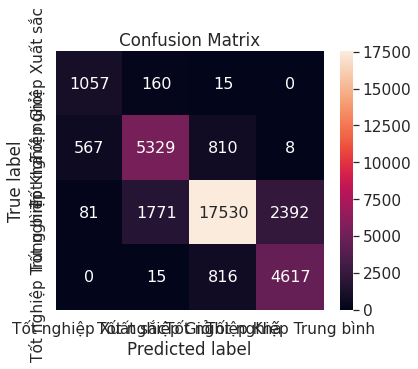

In [61]:
# xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,   #Fix n_estimator to 150 
#               colsample_bynode=1, colsample_bytree=0.7, gamma=0.4,
#               learning_rate=0.1, max_delta_step=0, max_depth=4,
#               min_child_weight=4, missing=None, n_estimators=119, n_jobs=-1,
#               nthread=None, objective='multi:softprob', random_state=0,
#               reg_alpha=0.5, reg_lambda=0, scale_pos_weight=1, seed=None,
#               silent=None, subsample=1, verbosity=1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

Weighted F1-score on the test set: 0.8036500992536096


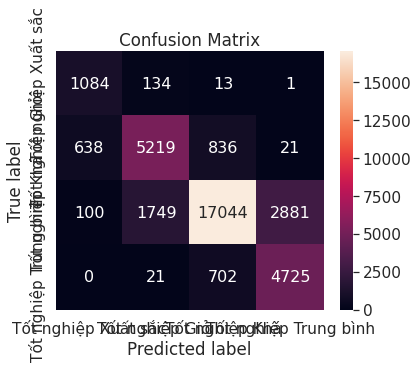

In [62]:
xgb1 = XGBClassifier()
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict['Random Forest'] = score
conf_mat(y_pred, y_test)

In [64]:
f1_dict_ht = {}

# Hyperparameter tuning for Random Forest
cv = KFold(n_splits = 5, shuffle = True, random_state = 20).split(X = X_train, y = y_train)
xgb2 = XGBClassifier()
params_xgb = { "learning_rate":[0.01,0.1,0.001], 
              "max_depth": [3,5,7],        
              "n_estimators": [100,500,200],
              "subsample": [0.6,0.8,1]
              }  
gsearch_xgb = GridSearchCV(estimator = xgb2, param_grid = params_xgb, scoring = 'f1_weighted', n_jobs = -1, cv = cv, verbose = 3)
gsearch_xgb_fit = gsearch_xgb.fit(X = X_train, y = y_train)
print("Best parameters: {}".format(gsearch_xgb.best_params_))
print("Best weighted F1-score: {}".format(gsearch_xgb.best_score_))
print(" ")

# Random Forest model evaluation on the test set
xgb_best = gsearch_xgb.best_estimator_
xgb_best.fit(X_train, y_train)
y_pred_rf = xgb_best.predict(X_test)
score = f1_score(y_test, y_pred_rf, average = 'weighted')
print("Weighted F1-score on the test set: {}".format(score))
f1_dict_ht['Random Forest'] = score
conf_mat(y_pred_rf, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-06f81434c931>", line 12, in <module>
    gsearch_xgb_fit = gsearch_xgb.fit(X = X_train, y = y_train)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 851, in evaluate_candidates
    enumerate(candidate_params), enumerate(cv.split(X, y, groups))
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1056, in __call__
    self.retrieve()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 93

KeyboardInterrupt: ignored